<a href="https://colab.research.google.com/github/aakarshit28/UIDAI_HACK/blob/main/UIDIA_HACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install rapidfuzz



In [29]:
import pandas as pd
import numpy as np
import re
import os
from google.colab import files



In [47]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

if filename.endswith('.csv'):
    df = pd.read_csv(filename)
elif filename.endswith('.xlsx'):
    df = pd.read_excel(filename)
else:
    raise Exception("Upload only CSV or Excel")

print("DF Columns:", df.columns.tolist())
print("DF Shape:", df.shape)

df.head()


Saving api_data_aadhar_biometric.xlsx to api_data_aadhar_biometric.xlsx
DF Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17']
DF Shape: (500000, 6)


,date,state,district,pincode,bio_age_5_17,bio_age_17
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Bihar,Madhepura,852121,144,369
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091
3,2025-03-01,Bihar,Bhojpur,802158,256,980
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815


In [48]:
uploaded = files.upload()
master_filename = list(uploaded.keys())[0]

master = pd.read_excel(master_filename)

print("Master Columns:", master.columns.tolist())
print("Master Shape:", master.shape)

master.head()


Saving All_Districts_of_India_2026.xlsx to All_Districts_of_India_2026.xlsx
Master Columns: ['State/UT', 'District']
Master Shape: (788, 2)


,State/UT,District
0,Andhra Pradesh,Alluri Sitharama Raju
1,Andhra Pradesh,Anakapalli
2,Andhra Pradesh,Anantapur
3,Andhra Pradesh,Annamayya
4,Andhra Pradesh,Bapatla


In [49]:
df.columns = df.columns.str.strip()
master.columns = master.columns.str.strip()

print("Clean DF Columns:", df.columns.tolist())
print("Clean MASTER Columns:", master.columns.tolist())


Clean DF Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17']
Clean MASTER Columns: ['State/UT', 'District']


In [50]:

print("Original DF Columns:", df.columns.tolist())

# It Convert columns to lowercase for matching
df.columns = df.columns.str.strip().str.lower()
master.columns = master.columns.str.strip().str.lower()

print("Lowercase DF Columns:", df.columns.tolist())
print("Lowercase MASTER Columns:", master.columns.tolist())

# This helps to Auto-detect possible names
state_candidates = ["state/ut", "state", "state_ut", "state ut"]
district_candidates = ["district", "dist"]


df_state_col = next((c for c in df.columns if c in state_candidates), None)
df_district_col = next((c for c in df.columns if c in district_candidates), None)

# Find matching column names in master
master_state_col = next((c for c in master.columns if c in state_candidates), None)
master_district_col = next((c for c in master.columns if c in district_candidates), None)

print("Detected DF State Column:", df_state_col)
print("Detected DF District Column:", df_district_col)
print("Detected MASTER State Column:", master_state_col)
print("Detected MASTER District Column:", master_district_col)

# Stops if not found
if df_state_col is None or df_district_col is None:
    raise Exception("State or District column not found in DF")

if master_state_col is None or master_district_col is None:
    raise Exception("State or District column not found in MASTER")

print("Basic text standardization done")


Original DF Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17']
Lowercase DF Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17']
Lowercase MASTER Columns: ['state/ut', 'district']
Detected DF State Column: state
Detected DF District Column: district
Detected MASTER State Column: state/ut
Detected MASTER District Column: district
Basic text standardization done


In [51]:
from rapidfuzz import process, fuzz
master_states = master[master_state_col].unique().tolist()
master_districts = master[master_district_col].unique().tolist()


def correct_state(state):
    if pd.isna(state):
        return state
    match = process.extractOne(state, master_states, scorer=fuzz.WRatio)
    return match[0] if match and match[1] >= 85 else state

def correct_district(district):
    if pd.isna(district):
        return district
    match = process.extractOne(district, master_districts, scorer=fuzz.WRatio)
    return match[0] if match and match[1] >= 85 else district

print("Fuzzy correction functions ready ")



Fuzzy correction functions ready 


In [52]:
df["state_temp"] = df[df_state_col].apply(correct_state)
df["district_temp"] = df[df_district_col].apply(correct_district)
print("Fuzzy correction applied ")



Fuzzy correction applied 


In [54]:
df = df.merge(master,
              left_on="district_temp",
              right_on=master_district_col,
              how="left",
              suffixes=("", "_master"))

df["state_final"] = df[f"{master_state_col}_master"].combine_first(df["state_temp"])
df["district_final"] = df["district_temp"]


In [55]:
unmatched = df[df[f"{master_state_col}_master"].isna()]

print("Unmatched location records:", unmatched.shape)

unmatched.to_csv("unmatched_locations.csv", index=False)
files.download("unmatched_locations.csv")

print("Unmatched locations file saved ")



Unmatched location records: (28821, 14)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unmatched locations file saved 


In [56]:
df_clean = df[df[f"{master_state_col}_master"].notna()].copy()

df_clean.drop([
    df_state_col,
    df_district_col,
    "state_temp",
    "district_temp",
    f"{master_state_col}_master",
    f"{master_district_col}_master"
], axis=1, inplace=True)

df_clean.rename(columns={
    "state_final": "state",
    "district_final": "district"
}, inplace=True)

print("Geo-standardized dataset shape:", df_clean.shape)
df_clean.head()


Geo-standardized dataset shape: (482453, 7)


,date,pincode,bio_age_5_17,bio_age_17,state/ut,state,district
0,2025-03-01,123029,280,577,Haryana,Haryana,Mahendragarh
1,2025-03-01,852121,144,369,Bihar,Bihar,Madhepura
3,2025-03-01,802158,256,980,Bihar,Bihar,Bhojpur
4,2025-03-01,625514,271,815,Tamil Nadu,Tamil Nadu,Madurai
5,2025-03-01,416702,155,529,Maharashtra,Maharashtra,Ratnagiri


In [57]:
df_clean["pincode"] = df_clean["pincode"].astype(str).str.strip()
df_clean = df_clean[df_clean["pincode"].str.match(r"^\d{6}$")]
df_clean["pincode"] = df_clean["pincode"].astype(int)

print("Pincode cleaned ")


Pincode cleaned 


In [58]:
df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
df_clean.dropna(subset=["date"], inplace=True)

df_clean["year"] = df_clean["date"].dt.year
df_clean["month"] = df_clean["date"].dt.month

print("Date formatting done ")


Date formatting done 


In [59]:
bio_cols = ["bio_age_5_17", "bio_age_17"]

for col in bio_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
    df_clean[col] = df_clean[col].fillna(0).astype(int)
    df_clean = df_clean[df_clean[col] >= 0]

print("Biometric columns cleaned")


Biometric columns cleaned


In [60]:
for col in bio_cols:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr

    df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])

print("Outliers capped ")


Outliers capped 


In [61]:
print(df_clean.isnull().sum())
print("Final Clean Shape:", df_clean.shape)

df_clean.head()


date            0
pincode         0
bio_age_5_17    0
bio_age_17      0
state/ut        0
state           0
district        0
year            0
month           0
dtype: int64
Final Clean Shape: (482453, 9)


,date,pincode,bio_age_5_17,bio_age_17,state/ut,state,district,year,month
0,2025-03-01,123029,63.5,57.0,Haryana,Haryana,Mahendragarh,2025,3
1,2025-03-01,852121,63.5,57.0,Bihar,Bihar,Madhepura,2025,3
3,2025-03-01,802158,63.5,57.0,Bihar,Bihar,Bhojpur,2025,3
4,2025-03-01,625514,63.5,57.0,Tamil Nadu,Tamil Nadu,Madurai,2025,3
5,2025-03-01,416702,63.5,57.0,Maharashtra,Maharashtra,Ratnagiri,2025,3


In [63]:
df_clean.to_csv("aadhaar_bio_updates_FINAL_CLEAN.csv", index=False)
files.download("aadhaar_bio_updates_FINAL_CLEAN.csv")

print("Final clean dataset saved")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final clean dataset saved


In [64]:
print("Records per State:")
print(df_clean["state"].value_counts())

print("\nTop 20 Districts:")
print(df_clean["district"].value_counts().head(20))


Records per State:
state
Tamil Nadu                                  46554
Uttar Pradesh                               43776
Maharashtra                                 37695
West Bengal                                 31884
Andhra Pradesh                              30775
Telangana                                   30711
Karnataka                                   28291
Kerala                                      25502
Bihar                                       25225
Odisha                                      24503
Rajasthan                                   24064
Gujarat                                     22285
Madhya Pradesh                              18051
Assam                                       13212
Chhattisgarh                                12738
Punjab                                      11756
Himachal Pradesh                            10193
Jharkhand                                    9208
Uttarakhand                                  7040
Haryana                  

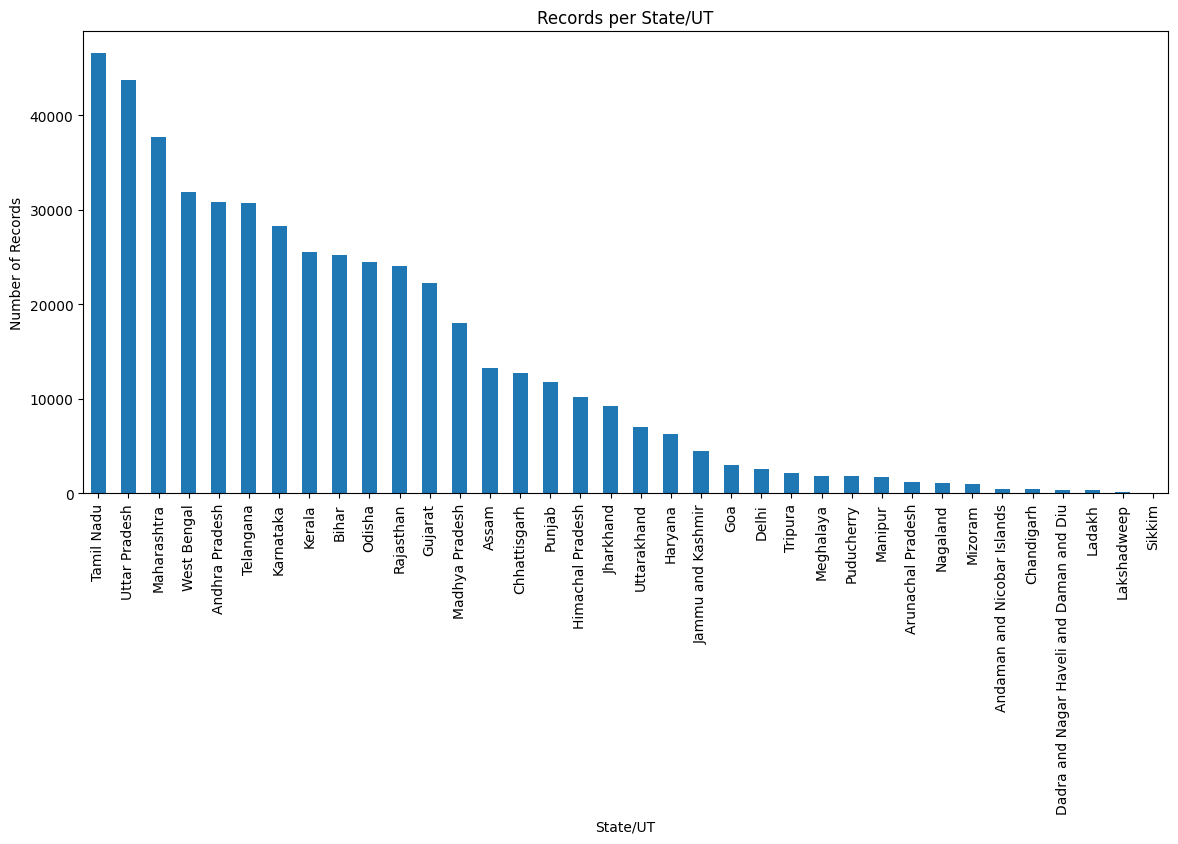

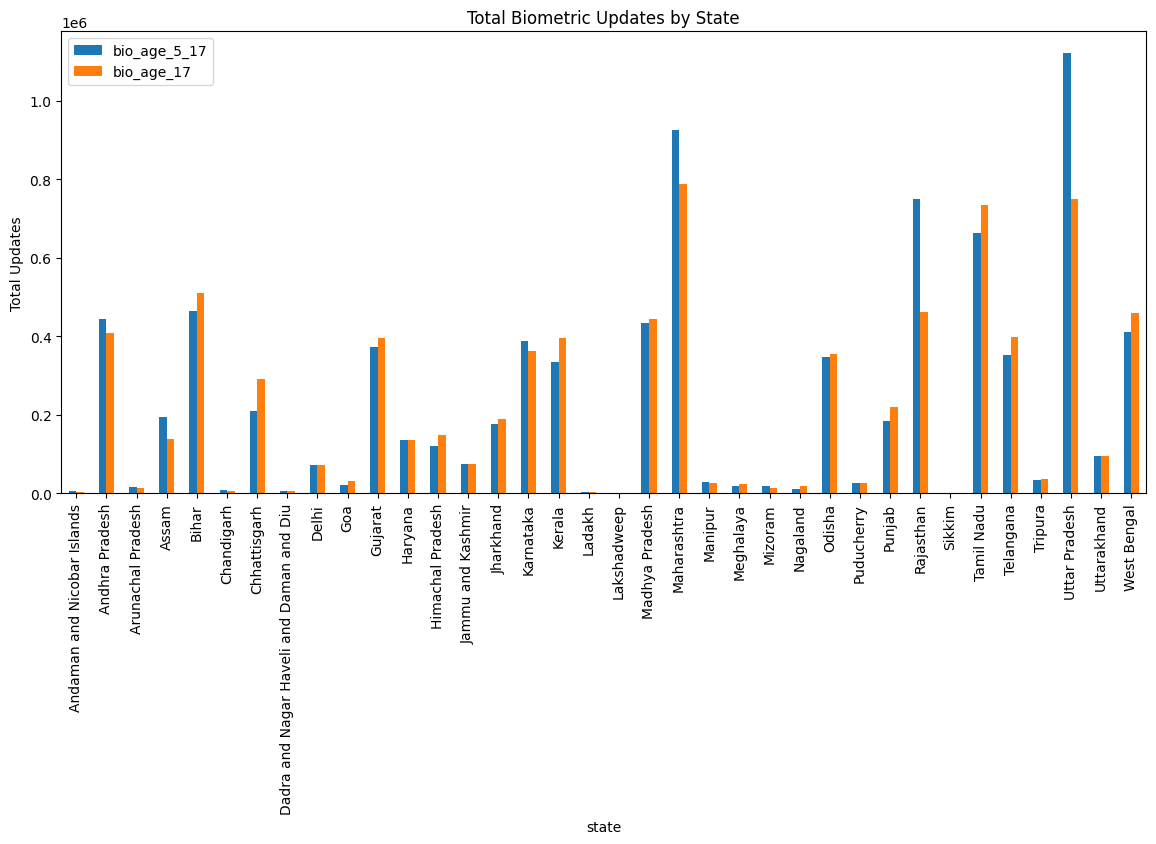

Dashboard generated 


In [65]:
import matplotlib.pyplot as plt

# Records per State
state_counts = df_clean["state"].value_counts()

plt.figure(figsize=(14,6))
state_counts.plot(kind="bar")
plt.title("Records per State/UT")
plt.xlabel("State/UT")
plt.ylabel("Number of Records")
plt.xticks(rotation=90)
plt.show()

# Biometric totals by State
bio_summary = df_clean.groupby("state")[bio_cols].sum()

bio_summary.plot(kind="bar", figsize=(14,6))
plt.title("Total Biometric Updates by State")
plt.ylabel("Total Updates")
plt.xticks(rotation=90)
plt.show()

print("Dashboard generated ")


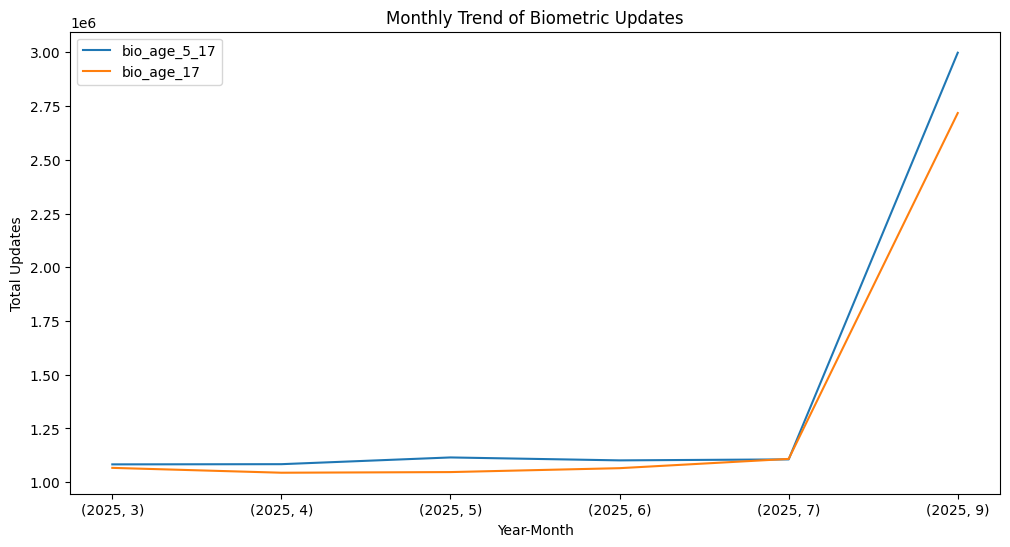

In [66]:
monthly_trend = df_clean.groupby(["year", "month"])[bio_cols].sum()

monthly_trend.plot(figsize=(12,6))
plt.title("Monthly Trend of Biometric Updates")
plt.ylabel("Total Updates")
plt.xlabel("Year-Month")
plt.show()


In [67]:
state_total = df_clean.groupby("state")[bio_cols].sum()
state_total["total_updates"] = state_total.sum(axis=1)

top_states = state_total.sort_values("total_updates", ascending=False).head(10)

top_states


,bio_age_5_17,bio_age_17,total_updates
state,,,
Uttar Pradesh,1121430.0,750758.0,1872188.0
Maharashtra,925594.0,787742.0,1713336.0
Tamil Nadu,663578.0,734785.0,1398363.0
Rajasthan,750036.0,461003.0,1211039.0
Bihar,465398.5,511045.0,976443.5
Madhya Pradesh,435270.0,445177.0,880447.0
West Bengal,411549.5,458753.0,870302.5
Andhra Pradesh,445080.5,407907.0,852987.5
Gujarat,374024.5,396759.0,770783.5


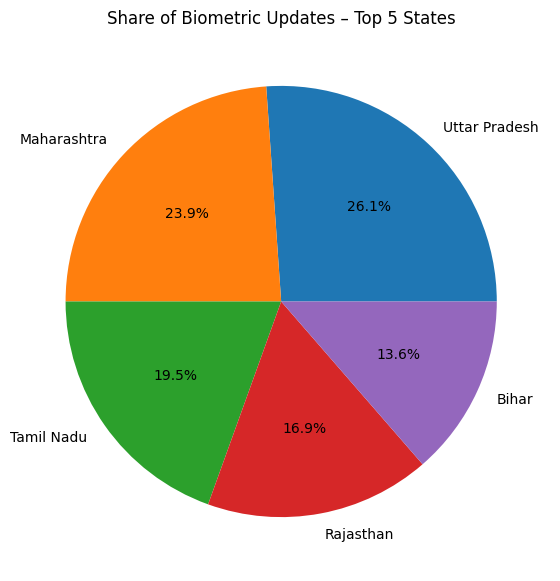

In [68]:
top5 = top_states["total_updates"].head(5)

plt.figure(figsize=(7,7))
plt.pie(top5, labels=top5.index, autopct='%1.1f%%')
plt.title("Share of Biometric Updates – Top 5 States")
plt.show()


In [69]:
district_total = df_clean.groupby(["state","district"])[bio_cols].sum()
district_total["total_updates"] = district_total.sum(axis=1)

district_total.sort_values("total_updates", ascending=False).head(15)


bio_age_5_17  bio_age_17  total_updates
state          district                                                  
Maharashtra    Pune                    75584.0     61155.0       136739.0
Uttar Pradesh  Pratapgarh              64256.0     39294.0       103550.0
Rajasthan      Pratapgarh              64256.0     39294.0       103550.0
Maharashtra    Mumbai City             47616.0     51583.0        99199.0
               Ahmednagar              60754.0     37780.0        98534.0
               Nashik                  51266.5     46538.0        97804.5
West Bengal    Paschim Bardhaman       41538.5     48999.0        90537.5
Andhra Pradesh East Godavari           47478.5     42000.0        89478.5
Rajasthan      Jaipur                  52441.0     36791.0        89232.0
West Bengal    North 24 Parganas       41311.0     47470.0        88781.0
Telangana      Hyderabad               39950.5     44810.0        84760.5
Maharashtra    Thane                   39027.0     44400.0        83427.0
Tamil Nadu     Viluppuram              39777.0     42858.0        82635.0
Maharashtra    Solapur                 48563.5     33505.0        82068.5
Kerala         Thrissur                36857.0     44669.0        81526.0

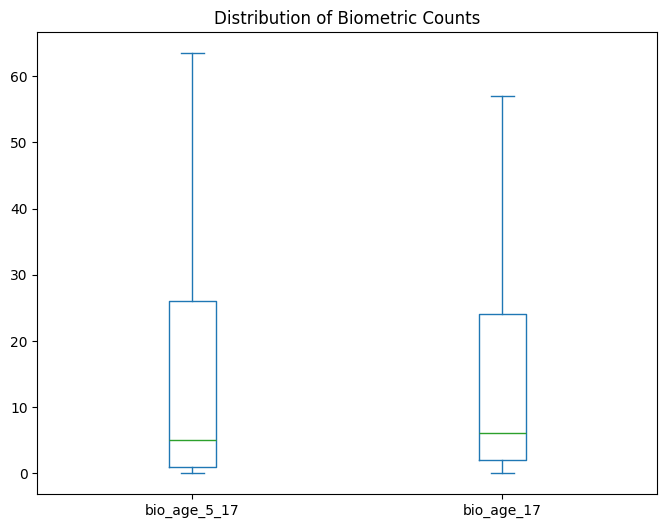

In [70]:
df_clean[bio_cols].plot(kind="box", figsize=(8,6))
plt.title("Distribution of Biometric Counts")
plt.show()


In [71]:
corr = df_clean[bio_cols].corr()
corr


,bio_age_5_17,bio_age_17
bio_age_5_17,1.000000,0.877996
bio_age_17,0.877996,1.000000


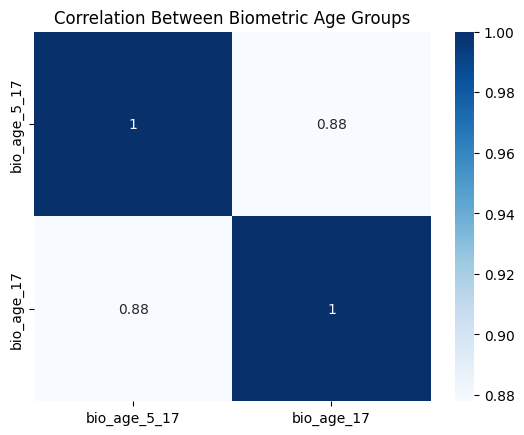

In [72]:
import seaborn as sns

sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Between Biometric Age Groups")
plt.show()


In [73]:
summary_report = state_total.copy()
summary_report.to_excel("Statewise_Biometric_Summary.xlsx")

files.download("Statewise_Biometric_Summary.xlsx")

print("Analytical summary report exported ")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Analytical summary report exported 


In [74]:
# State-wise biometric sums
state_bio = df_clean.groupby("state")[bio_cols].sum()

# Compute ratio safely (avoid division by zero)
state_bio["ratio_5_17_to_17"] = (
    state_bio["bio_age_5_17"] / state_bio["bio_age_17"].replace(0, np.nan)
)

# Sort and take top 10
top10_ratio = state_bio.sort_values("ratio_5_17_to_17", ascending=False).head(10)

print("Top 10 States by bio_age_5_17 to bio_age_17 Ratio:")
top10_ratio


Top 10 States by bio_age_5_17 to bio_age_17 Ratio:


,bio_age_5_17,bio_age_17,ratio_5_17_to_17
state,,,
Rajasthan,750036.0,461003.0,1.626966
Uttar Pradesh,1121430.0,750758.0,1.493730
Assam,195588.5,138492.0,1.412273
Andaman and Nicobar Islands,5988.5,4474.0,1.338511
Mizoram,18442.5,13794.0,1.336994
Arunachal Pradesh,16155.0,13330.0,1.211928
Maharashtra,925594.0,787742.0,1.174996
Manipur,29177.0,25516.0,1.143479
Ladakh,3616.0,3214.0,1.125078


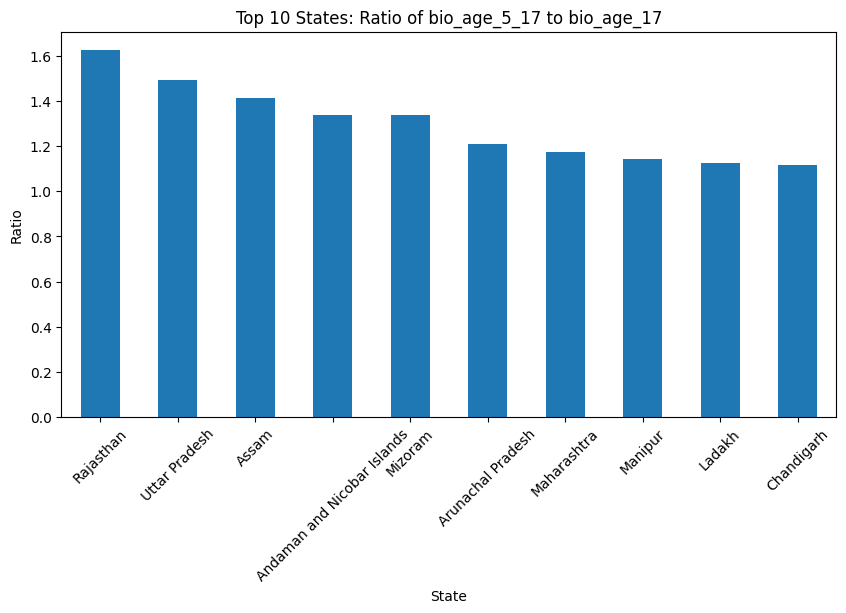

In [75]:
plt.figure(figsize=(10,5))

top10_ratio["ratio_5_17_to_17"].plot(kind="bar")

plt.title("Top 10 States: Ratio of bio_age_5_17 to bio_age_17")
plt.ylabel("Ratio")
plt.xlabel("State")
plt.xticks(rotation=45)

plt.show()


In [76]:
# Aggregate biometric sums per state
state_bio = df.groupby("state")[bio_cols].sum()

# Compute conversion rate
state_bio["conversion_rate"] = (
    state_bio["bio_age_5_17"] / (state_bio["bio_age_5_17"] + state_bio["bio_age_17"])
)

# Remove states with zero total updates (safety)
state_bio = state_bio.dropna(subset=["conversion_rate"])

# Top 5 best performing states
top5_best = state_bio.sort_values("conversion_rate", ascending=False).head(5)



print("🏆 Top 5 Best Performing States (High Conversion Rate):")
display(top5_best[["bio_age_5_17", "bio_age_17", "conversion_rate"]])


🏆 Top 5 Best Performing States (High Conversion Rate):


,bio_age_5_17,bio_age_17,conversion_rate
state,,,
west Bengal,1,0,1.000000
Mizoram,74799,30236,0.712134
Chandigarh,43266,19574,0.688511
Uttar Pradesh,4776084,2466768,0.659420
Assam,373246,205556,0.644860


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'west Bengal'),
  Text(1, 0, 'Mizoram'),
  Text(2, 0, 'Chandigarh'),
  Text(3, 0, 'Uttar Pradesh'),
  Text(4, 0, 'Assam')])

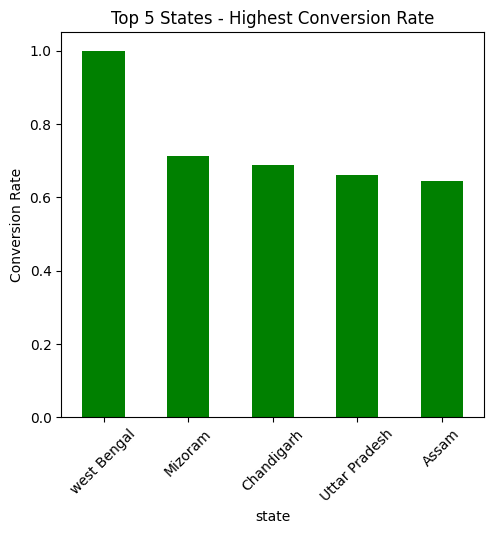

In [77]:
plt.figure(figsize=(12,5))

# Plot Best
plt.subplot(1,2,1)
top5_best["conversion_rate"].plot(kind="bar", color="green")
plt.title("Top 5 States - Highest Conversion Rate")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)


